In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import copy
import warnings
import random

random.seed(42)

%matplotlib inline

In [3]:
au_df = pd.read_csv('AU_df.csv', index_col=False)
voice_df = pd.read_csv('audio_full.csv', index_col=False)
speech_df = pd.read_csv('speech_content_data.csv', index_col=False)
eye_df = pd.read_csv('eye_movement.csv', index_col=False)
bellevue_df = pd.read_csv('Bellevue_final_data.csv', index_col=False)

bellevue_clean_df = bellevue_df.iloc[:, 0:4]
bellevue_clean_df.rename(columns={'pcl_1m_cutoff': 'PTSD', 'SelfReport_Age': 'Age'}, inplace=True)

merged_df = bellevue_clean_df.merge(au_df, on='ID')
merged_df = merged_df.merge(voice_df, on='ID')
merged_df = merged_df.merge(speech_df, on='ID')
merged_df = merged_df.merge(eye_df, on='ID')


merged_df = merged_df.dropna()
merged_df = merged_df.drop('AUD_INTENSITY_FRAMES', axis=1)
merged_df = merged_df.drop('AUD_FF_FRAMES', axis=1)
merged_df = merged_df.drop('AUD_HNR_FRAMES', axis=1)
merged_df = merged_df.drop('AUD_GNE_FRAMES', axis=1)
merged_df = merged_df.drop('AUD_GNE_MIN', axis=1)
merged_df = merged_df.drop('VOICE_FRAME_COUNT', axis=1)


merged_df.to_csv('merged_df.csv')

train_data = merged_df.drop('ID', axis=1)
labels = merged_df['PTSD']
train_data = train_data.drop('PTSD', axis=1)

train_data2 = copy.deepcopy(train_data) ## deep copy before normalizing the data
train_data = StandardScaler().fit_transform(train_data)




In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
plt.clf()
### ROC CURVES 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
def get_ROC(y_pred, y_true):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label = 'AUC: %.3f ' % roc_auc[i], color='purple', lw=2)
        plt.plot([0, 1], [0, 1], color='lightgrey', lw=2, linestyle='-')
        plt.legend(loc="lower right")
        plt.grid(color='whitesmoke', lw=0.5)
        plt.title('Logistic Regression: Merged Dataset', size=14)
        plt.xlabel('Specificity')
        plt.ylabel('Sensitivity')
        plt.savefig('AUC_LR.png', format='png', dpi=1000)

<Figure size 432x288 with 0 Axes>

In [6]:
train_class, test_class, train_labels, test_labels = train_test_split(train_data, labels, test_size = 0.20, random_state = 42)
print('Training Features Shape:', train_class.shape)
print('Training Labels Shape:\t', train_labels.shape)
print('Testing Features Shape:\t', test_class.shape)
print('Testing Labels Shape:\t', test_labels.shape)

Training Features Shape: (59, 173)
Training Labels Shape:	 (59,)
Testing Features Shape:	 (15, 173)
Testing Labels Shape:	 (15,)


In [7]:
def RFE_model(model, data, labels, train_data, num_attr=3):
    """Generate an RFE model given any previous model; number of attributes defaults to 3 but can
    be changed. Returns a dictionary with feature name as the key and ranking/support of RFE as value."""
    rfe = RFE(model, num_attr)
    rfe = rfe.fit(data, labels)
    # Creating the feature dictionary
    feat_dict = {}
    count = 0
    for col in train_data.columns:
        feat_dict[col] = [rfe.ranking_[count], rfe.support_[count]]
        count +=1
    return feat_dict

def get_important_features(feat_dict):
    """Getting a print out of the most important features in the model"""
    imp_feat = []
    for k, v in feat_dict.items():
        if v[0] == 1: # looking only for features labelled as number 1
            imp_feat.append(k)
    return imp_feat
    


### Logistic Regression

0.5333333333333333
0.6
0.6666666666666666
0.6666666666666666


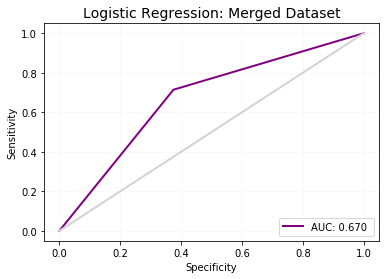

In [16]:
lr = LogisticRegression()


def lr_RFE(model, train_class, train_labels, data):
    best_acc = 0
    selected_feat = None
    optimal_feat = 0
    for i in range(1,train_class.shape[1]):
        num_feat = i
        feat_dict = RFE_model(model, train_class, train_labels, data, i)
        imp_feat = get_important_features(feat_dict)
        
        train_data_rfe = copy.deepcopy(train_data2)
        for col in train_data_rfe.columns:
            if col not in imp_feat:
                train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
        train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
        train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
        
        lr.fit(train_class_rfe, train_labels_rfe)
        lr_pred_rfe = lr.predict(test_class_rfe)
        lr_acc = metrics.accuracy_score(lr_pred_rfe, test_labels_rfe)
        
        if lr_acc >= best_acc and  i < 40:
            selected_feat = imp_feat
            best_acc = lr_acc
            optimal_feat = i
            y_pred = lr_pred_rfe
            y_true = test_labels_rfe
            print(best_acc)
#     plt.tight_layout()
#     plt.subplot(2, 1, 1)
    get_ROC(y_pred, y_true)
#     plt.subplot(2, 1, 2)
#     conf_mat = metrics.confusion_matrix(y_true, y_pred)
#     plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
#                       title='Confusion matrix for Logistic Regression')
    return optimal_feat,  best_acc, selected_feat, y_pred
optimal_feat, best_acc, selected_feat, lr_pred_2 = lr_RFE(lr, train_class, train_labels, train_data2)

In [18]:
lr_f1= metrics.f1_score(test_labels, lr_pred_2)
print(lr_f1)

0.6666666666666666


0.5333333333333333
0.5333333333333333
0.6
0.6
0.6
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.7333333333333333
0.7333333333333333


(21,
 0.7333333333333333,
 ['feel',
  'pronoun',
  'risk',
  'sad',
  'see',
  'shehe',
  'social',
  'tentat',
  'time',
  'we',
  'clout',
  'wps',
  'analytic',
  'dic',
  'authentic',
  'HEAD_MOVEMENT',
  'EYE_MOVEMENT_LEFT',
  'EYE_MOVEMENT_RIGHT',
  'PUPIL_SIZE_LEFT',
  'PUPIL_DIA_LEFT',
  'PUPIL_DIA_RIGHT'])

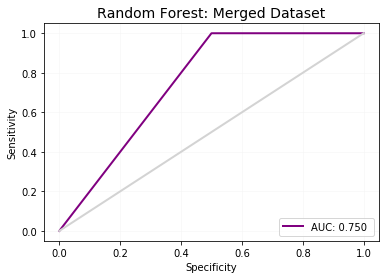

In [71]:
RF = RandomForestClassifier()


def RF_RFE(model, train_class, train_labels, data):
    best_acc = 0
    selected_feat = None
    optimal_feat = 0
    for i in range(1,train_class.shape[1]):
        num_feat = i
        feat_dict = RFE_model(model, train_class, train_labels, data, i)
        imp_feat = get_important_features(feat_dict)
        
        train_data_rfe = copy.deepcopy(train_data2)
        for col in train_data_rfe.columns:
            if col not in imp_feat:
                train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
        train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
        train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
        
        rf.fit(train_class_rfe, train_labels_rfe)
        rf_pred_rfe = rf.predict(test_class_rfe)
        rf_acc = metrics.accuracy_score(rf_pred_rfe, test_labels_rfe)
        
        if rf_acc >= best_acc and i <=30:
            selected_feat = imp_feat
            best_acc = rf_acc
            optimal_feat = i
            y_pred = rf_pred_rfe
            y_true = test_labels_rfe
            print(best_acc)
#     plt.tight_layout()
#     plt.subplot(2, 1, 1)
    get_ROC(y_pred, y_true)
#     plt.subplot(2, 1, 2)
#     conf_mat = metrics.confusion_matrix(y_true, y_pred)
#     plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
#                       title='Confusion matrix for Logistic Regression')
    return optimal_feat,  best_acc, selected_feat
RF_RFE(rf, train_class, train_labels, train_data2)

In [12]:
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 20, 50]
    gammas = [0.001, 0.01, 0.1, 1, 2]
    kernel = ['linear']
    max_iter = [-1, 1, 5, 10, 100, 1000]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernel, 'max_iter': max_iter}
    grid_search = GridSearchCV(svm.SVC(), param_grid)#, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

p = svc_param_selection(train_class, train_labels, 2)

0.4666666666666667
Confusion matrix, without normalization
[[7 0]
 [8 0]]


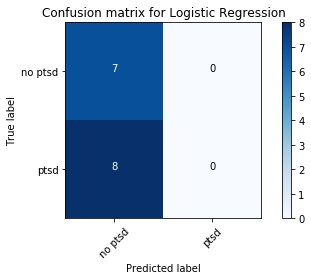

(1, 0.4666666666666667, [' AU20_r'])

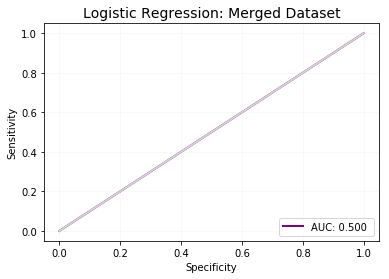

In [15]:
svm_lin =svm.SVC(kernel='linear', C=0.001)


def SVM_RFE(model, train_class, train_labels, data):
    best_acc = 0
    selected_feat = None
    optimal_feat = 0
    for i in range(1,train_class.shape[1]):
        num_feat = i
        feat_dict = RFE_model(model, train_class, train_labels, data, i)
        imp_feat = get_important_features(feat_dict)
        
        train_data_rfe = copy.deepcopy(train_data2)
        for col in train_data_rfe.columns:
            if col not in imp_feat:
                train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
        train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
        train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
        
        svm_lin.fit(train_class_rfe, train_labels_rfe)
        svm_lin_pred_rfe = svm_lin.predict(test_class_rfe)
        svm_lin_acc = metrics.accuracy_score(svm_lin_pred_rfe, test_labels_rfe)
        
        if svm_lin_acc > best_acc:
            selected_feat = imp_feat
            best_acc = svm_lin_acc
            optimal_feat = i
            y_pred = svm_lin_pred_rfe
            y_true = test_labels_rfe
            print(best_acc)

    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Logistic Regression')
    plt.show()
    get_ROC(y_pred, y_true)
    
    
    return optimal_feat,  best_acc, selected_feat
SVM_RFE(svm_lin, train_class, train_labels, train_data2)

In [21]:
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
def lr_param_selection(X, y):
    Cs = [0.0001,0.001, 0.01, 0.1, 1, 10, 20, 50]
    max_iter = [1,10, 100, 1000, 10000, 20000]
    solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    class_weight = [None, 'balanced']
    param_grid = {'C': Cs,  'solver': solver, 'max_iter' : max_iter, 'class_weight': class_weight}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, verbose=False)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

lr_params = lr_param_selection(train_class, train_labels)
print(lr_params)

{'C': 0.0001, 'class_weight': None, 'max_iter': 1, 'solver': 'sag'}


In [7]:
lr = LogisticRegression(C = 0.0001, class_weight= None , max_iter = 1, solver= 'sag')
#lr = LogisticRegression(C = 0.1, class_weight= None , max_iter = 10, solver= 'newton-cg')


lr.fit(train_class, train_labels)
lr_pred = lr.predict(test_class)
lr_acc = metrics.accuracy_score(lr_pred, test_labels)
print('Logistic Regression Accuracy: ', lr_acc)
conf_mat = metrics.confusion_matrix(test_labels, lr_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Logistic Regression')



/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

Optimal number of features : 81
(59, 62)


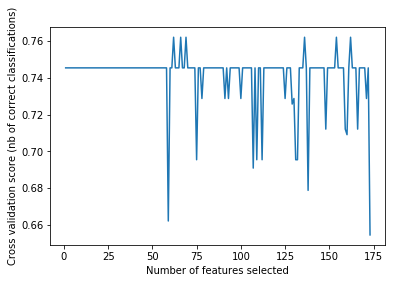

In [24]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
random.seed(42)

rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')

rfecv.fit(train_class, train_labels)
print("Optimal number of features : %d" % rfecv.n_features_)
rfecv
X_new = rfecv.fit_transform(train_class, train_labels)
print(X_new.shape)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [17]:
random.seed(42)
feat_dict = RFE_model(lr, train_class, train_labels, train_data2, 14)
imp_feat = get_important_features(feat_dict)
print(imp_feat)

[' AU05_r', ' AU09_r', ' AU09_c', 'anx', 'compare', 'feel', 'function', 'i', 'interrog', 'motion', 'negemo', 'ppron', 'pronoun', 'PUPIL_CENTER_LEFT']


/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

In [30]:
train_data_rfe = copy.deepcopy(train_data2)
for col in train_data_rfe.columns:
    if col not in imp_feat:
        train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
lr_param_selection(train_class_rfe, train_labels_rfe)

{'C': 0.001, 'class_weight': 'balanced', 'max_iter': 10, 'solver': 'saga'}

Logistic Regression Accuracy:  0.4666666666666667
Confusion matrix, without normalization
[[7 0]
 [8 0]]


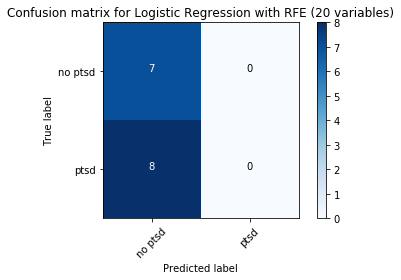

In [31]:
lr = LogisticRegression(C = 0.0001, class_weight= None , max_iter = 1, solver= 'saga')


lr.fit(train_class_rfe, train_labels_rfe)
lr_pred = lr.predict(test_class_rfe)
lr_acc = metrics.accuracy_score(lr_pred, test_labels_rfe)
print('Logistic Regression Accuracy: ', lr_acc)
conf_mat = metrics.confusion_matrix(test_labels_rfe, lr_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Logistic Regression with RFE (20 variables)')

### Random Forest

In [32]:
warnings.filterwarnings('ignore')
def rf_param_selection(X, y):
    n_estimators = [1, 10, 20, 100, 1000]
    max_depth = [None, 10, 100, 200]
    max_features = ['auto','sqrt', None, 'log2']
    min_samples_split = [2,3,5,10]
    min_samples_leaf = [1,2,4]
    bootstrap = [True, False]
    param_grid = {'n_estimators': n_estimators, 
                  'max_depth': max_depth,
                  'max_features': max_features,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap
                 }
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, verbose=False)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

rf_params = rf_param_selection(train_class, train_labels)
print(rf_params)

KeyboardInterrupt: 

Random Forest Accuracy:  0.6
Confusion matrix, without normalization
[[7 0]
 [6 2]]


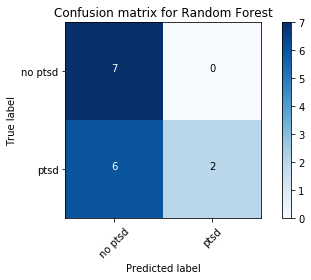

In [17]:
random.seed(42)
rf = RandomForestClassifier(bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10)
rf.fit(train_class, train_labels)
rf_pred = rf.predict(test_class)
rf_pred_prob = rf.predict_proba(test_class)
rf_acc = metrics.accuracy_score(rf_pred, test_labels)
print('Random Forest Accuracy: ', rf_acc)

conf_mat = metrics.confusion_matrix(test_labels, rf_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Random Forest')



In [18]:
random.seed(42)
rfecv = RFECV(estimator=rf, step=1, cv=5,
              scoring='accuracy')
rfecv.fit(train_class, train_labels)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

NameError: name 'RFECV' is not defined

In [38]:
random.seed(42)
feat_dict = RFE_model(rf, train_class, train_labels, train_data2, 50)
imp_feat = get_important_features(feat_dict)
print(imp_feat)

['function', 'hear', 'i', 'ingest', 'interrog', 'ipron', 'motion', 'negemo', 'netspeak', 'number', 'percept', 'posemo', 'power', 'ppron', 'prep', 'pronoun', 'quant', 'reward', 'risk', 'sad', 'see', 'space', 'we', 'work', 'you', 'clout', 'wps', 'analytic', 'tone', 'dic', 'authentic', 'HEAD_MOVEMENT', 'EYE_MOVEMENT_LEFT', 'EYE_MOVEMENT_RIGHT', 'PUPIL_SIZE_LEFT', 'PUPIL_SIZE_RIGHT', 'PUPIL_DIA_LEFT', 'PUPIL_DIA_RIGHT', 'PUPIL_CHANGE_LEFT', 'PUPIL_CHANGE_RIGHT', 'PUPIL_CENTER_LEFT', 'PUPIL_CENTER_RIGHT', 'PUPIL_DILRATE_LEFT', 'PUPIL_DILRATE_RIGHT', 'DILATION_RATIO_LEFT', 'DILATION_RATIO_RIGHT', 'GAZE_ANGLE', 'FIXATION_COUNT', 'FIXATION_DURATION', 'SACCADE_COUNT']


In [ ]:
train_data_rfe = copy.deepcopy(train_data2)
for col in train_data_rfe.columns:
    if col not in imp_feat:
        train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
rf_param_selection(train_class_rfe, train_labels_rfe)

In [ ]:
random.seed(42)
rf = RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2', min_samples_leaf=4, min_samples_split=5, n_estimators=1)
rf.fit(train_class, train_labels)
rf_pred = rf.predict(test_class)
rf_acc = metrics.accuracy_score(rf_pred, test_labels)
print('Random Forest Accuracy: ', rf_acc)

conf_mat = metrics.confusion_matrix(test_labels, rf_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Random Forest')

### Poly SVM

In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 20, 50]
    gammas = [0.001, 0.01, 0.1, 1, 2]
    kernel = ['poly']
    max_iter = [-1, 1, 5, 10, 100, 1000]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernel, 'max_iter': max_iter}
    grid_search = GridSearchCV(svm.SVC(), param_grid)#, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

print(svc_param_selection(train_class, train_labels, 10))

Poly SVM Accuracy:  0.4666666666666667
Confusion matrix, without normalization
[[7 0]
 [8 0]]


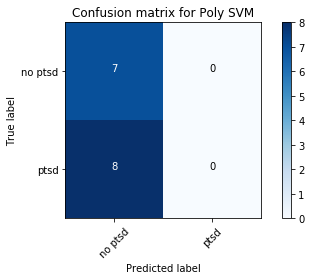

In [72]:
poly_svm = svm.SVC(kernel='poly')
poly_svm.fit(train_class, train_labels)
poly_svm_pred = poly_svm.predict(test_class)
svm_poly_acc = metrics.accuracy_score(poly_svm_pred, test_labels)
print('Poly SVM Accuracy: ', svm_poly_acc)
conf_mat = metrics.confusion_matrix(test_labels, poly_svm_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Poly SVM')

### Linear SVM

In [ ]:
random.seed(42)
lin_svm = svm.SVC(kernel='linear', C=1)
lin_svm.fit(train_class, train_labels)
lin_svm_pred = lin_svm.predict(test_class)
svm_lin_acc = metrics.accuracy_score(lin_svm_pred, test_labels)
print('Linear SVM Accuracy: ', svm_lin_acc)
conf_mat = metrics.confusion_matrix(lin_svm_pred, test_labels)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Linear SVM')

In [ ]:
random.seed(42)
rfecv = RFECV(estimator=lin_svm, step=1, cv=9,
              scoring='accuracy')
rfecv.fit(train_class, train_labels)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 20, 50]
    gammas = [0.001, 0.01, 0.1, 1, 2]
    kernel = ['linear']
    max_iter = [-1, 1, 5, 10, 100, 1000]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernel, 'max_iter': max_iter}
    grid_search = GridSearchCV(svm.SVC(), param_grid)#, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

random.seed(42)
feat_dict = RFE_model(lin_svm, train_class, train_labels, train_data2, 2)
imp_feat = get_important_features(feat_dict)
print(imp_feat)

train_data_rfe = copy.deepcopy(train_data2)
for col in train_data_rfe.columns:
    if col not in imp_feat:
        train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
svc_param_selection(train_class_rfe, train_labels_rfe, 2)

In [ ]:
random.seed(42)
lin_svm = svm.SVC(kernel='linear', C=1, gamma=0.001, max_iter=-1)
lin_svm.fit(train_class, train_labels)
lin_svm_pred = lin_svm.predict(test_class)
svm_lin_acc = metrics.accuracy_score(lin_svm_pred, test_labels)
print('Linear SVM Accuracy: ', svm_lin_acc)
conf_mat = metrics.confusion_matrix(lin_svm_pred, test_labels)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Linear SVM')

### Radial SVM

In [ ]:
rad_svm = svm.SVC(kernel='rbf', C=0.001, gamma=0.001, max_iter=-1)
rad_svm.fit(train_class, train_labels)
rad_svm_pred = rad_svm.predict(test_class)
svm_rad_acc = metrics.accuracy_score(rad_svm_pred, test_labels)
print('Radial SVM Accuracy: ', svm_rad_acc)
conf_mat = metrics.confusion_matrix(test_labels, rad_svm_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Radial SVM')

In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1, 2]
    kernel = ['rbf']
    max_iter = [-1, 1, 5, 10, 100, 1000]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernel, 'max_iter': max_iter}
    grid_search = GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

svc_param_selection(train_class, train_labels, 5)

In [ ]:
rad_svm = svm.SVC(kernel='rbf', C=0.0001, gamma=0.0001, max_iter=-1)
rad_svm.fit(train_class, train_labels)
rad_svm_pred = rad_svm.predict(test_class)
svm_rad_acc = metrics.accuracy_score(rad_svm_pred, test_labels)
print('Radial SVM Accuracy: ', svm_rad_acc)
conf_mat = metrics.confusion_matrix(test_labels, rad_svm_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Radial SVM')

## New Type of Feature Selection (from the get-go)

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

X_train_new = SelectKBest(mutual_info_classif, k=14).fit_transform(train_data2, labels)
X_train_new.shape



(74, 14)

In [16]:
train_class2, test_class2, train_labels2, test_labels2 = train_test_split(X_train_new, labels, test_size = 0.20, random_state = 0)
print('Training Features Shape:', train_class2.shape)
print('Training Labels Shape:\t', train_labels2.shape)
print('Testing Features Shape:\t', test_class2.shape)
print('Testing Labels Shape:\t', test_labels2.shape)

Training Features Shape: (59, 14)
Training Labels Shape:	 (59,)
Testing Features Shape:	 (15, 14)
Testing Labels Shape:	 (15,)


In [17]:
## LR
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
def lr_param_selection(X, y):
    Cs = [0.0001,0.001, 0.01, 0.1, 1, 10, 20, 50]
    max_iter = [1,10, 100, 1000, 10000, 20000]
    solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    class_weight = [None, 'balanced']
    param_grid = {'C': Cs,  'solver': solver, 'max_iter' : max_iter, 'class_weight': class_weight}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, verbose=False)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

lr_params = lr_param_selection(train_class2, train_labels2)
print(lr_params)

{'C': 0.01, 'class_weight': None, 'max_iter': 1, 'solver': 'sag'}


Logistic Regression Accuracy:  0.6666666666666666
Confusion matrix, without normalization
[[9 1]
 [4 1]]


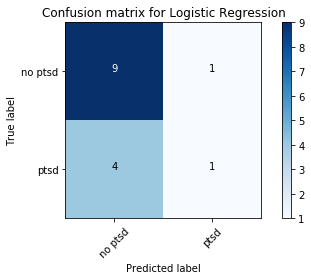

In [20]:
lr = LogisticRegression(C = 0.01, class_weight= None , max_iter = 1, solver= 'sag')
#lr = LogisticRegression(C = 0.1, class_weight= None , max_iter = 10, solver= 'newton-cg')


lr.fit(train_class2, train_labels2)
lr_pred2 = lr.predict(test_class2)
lr_acc2 = metrics.accuracy_score(lr_pred2, test_labels2)
print('Logistic Regression Accuracy: ', lr_acc2)
conf_mat = metrics.confusion_matrix(test_labels2, lr_pred2)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Logistic Regression')

get_R


In [ ]:
## RF
warnings.filterwarnings('ignore')
def rf_param_selection(X, y):
    n_estimators = [1, 10, 20, 100, 1000]
    max_depth = [None, 10, 100, 200]
    max_features = ['auto','sqrt', None, 'log2']
    min_samples_split = [2,3,5,10]
    min_samples_leaf = [1,2,4]
    bootstrap = [True, False]
    param_grid = {'n_estimators': n_estimators, 
                  'max_depth': max_depth,
                  'max_features': max_features,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap
                 }
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, verbose=False)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

rf_params = rf_param_selection(train_class2, train_labels2)
print(rf_params)

Random Forest Accuracy:  0.6666666666666666
Confusion matrix, without normalization
[[8 2]
 [3 2]]


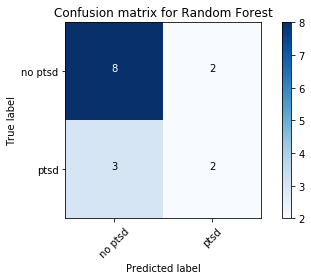

In [21]:
random.seed(42)
rf = RandomForestClassifier(bootstrap=True, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=20)
rf.fit(train_class2, train_labels2)
rf_pred2 = rf.predict(test_class2)
rf_acc2 = metrics.accuracy_score(rf_pred2, test_labels2)
print('Random Forest Accuracy: ', rf_acc2)

conf_mat = metrics.confusion_matrix(test_labels2, rf_pred2)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Random Forest')

In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1, 2]
    kernel = ['linear']
    max_iter = [-1, 1, 5, 10, 100, 1000]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernel, 'max_iter': max_iter}
    grid_search = GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

svc_param_selection(train_class2, train_labels2, 5)

Radial SVM Accuracy:  0.6666666666666666
Confusion matrix, without normalization
[[10  0]
 [ 5  0]]


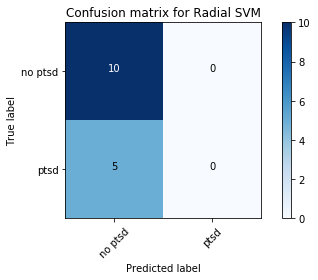

In [9]:
rad_svm2 = svm.SVC(kernel='rbf', C=0.0001, gamma=0.0001, max_iter=-1)

rad_svm2.fit(train_class2, train_labels2)
rad_svm_pred2 = rad_svm2.predict(test_class2)
svm_rad_acc2 = metrics.accuracy_score(rad_svm_pred2, test_labels2)
print('Radial SVM Accuracy: ', svm_rad_acc2)
conf_mat = metrics.confusion_matrix(test_labels2, rad_svm_pred2)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Radial SVM')

Linear SVM Accuracy:  0.5333333333333333
Confusion matrix, without normalization
[[7 4]
 [3 1]]


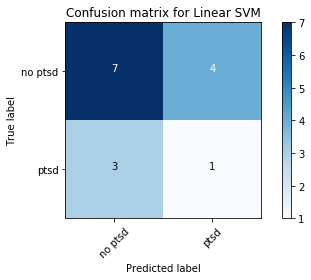

In [10]:
random.seed(42)
lin_svm2 = svm.SVC(kernel='linear', C=1, gamma=0.001, max_iter=-1)
lin_svm2.fit(train_class2, train_labels2)
lin_svm_pred2 = lin_svm2.predict(test_class2)
svm_lin_acc2 = metrics.accuracy_score(lin_svm_pred2, test_labels2)
print('Linear SVM Accuracy: ', svm_lin_acc2)
conf_mat = metrics.confusion_matrix(lin_svm_pred2, test_labels2)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Linear SVM')

In [ ]:
poly_svm2 = svm.SVC(kernel='poly', C=0.001, gamma=0.001, max_iter=-1)
poly_svm2.fit(train_class2, train_labels2)
poly_svm_pred2 = poly_svm2.predict(test_class2)
svm_poly_acc2 = metrics.accuracy_score(poly_svm_pred2, test_labels2)
print('Poly SVM Accuracy: ', svm_poly_acc2)
conf_mat = metrics.confusion_matrix(test_labels2, poly_svm_pred2)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Poly SVM')

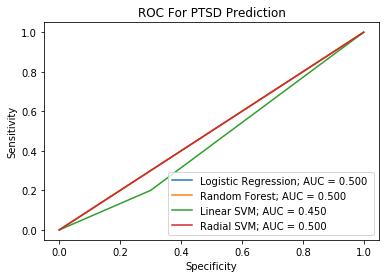

In [11]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(test_labels2, lr_pred2)
auc = metrics.roc_auc_score(test_labels2, lr_pred2)
plt.plot(fpr,tpr,label="Logistic Regression; AUC = %.3f "% auc)


fpr, tpr, thresh = metrics.roc_curve(test_labels2, rf_pred2)
auc = metrics.roc_auc_score(test_labels2, rf_pred2)
plt.plot(fpr,tpr,label="Random Forest; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels2, lin_svm_pred2)
auc = metrics.roc_auc_score(test_labels2, lin_svm_pred2)
plt.plot(fpr,tpr,label="Linear SVM; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels2, rad_svm_pred2)
auc = metrics.roc_auc_score(test_labels2, rad_svm_pred2)
plt.plot(fpr,tpr,label="Radial SVM; AUC = %.3f " % auc)

plt.title('ROC For PTSD Prediction')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc=4)
plt.savefig('ROC_Plot.png', format='png')

